<font size="+10">qpcr - Getting Started</font>
<br>

---

In this Notebook you will get some basic introduction to using the `qpcr` module. Including an overview of the main and submodules, input data and resulting outputs.

Installing `qpcr`
---
`qpcr` can be directly installed via `pip` using

```python
pip install qpcr
```

Basic structure of `qpcr`
----------------------------------------------------------------

The `qpcr` module consists of the "main" module that essentially defines everything you need
to work with your data and compute `Delta-Delta-Ct` values for your assays. However, it does not do so on its own but relies on a number of submodules to achieve this. For some features you will also directly have to work with these submodules. 

| Module | Description |
|---|---|
| `qpcr`          | The main `qpcr` module that defines the essentials for performing Delta-Delta-Ct analysis. |
| `qpcr.defaults` | Defines default settings and values for `qpcr`. These can be changed to affect `qpcr` globally. |
| `qpcr.Readers` | Defines the classes that will help read your input data files. |
| `qpcr.Plotters` | Defines classes that will allow you to quickly and easily visualise your results. |
| `qpcr.Filters` | Defines classes that allow you to filter out bad Ct values from your assays. |
| `qpcr.Parsers` | Defines classes that allow you to extract data from "irregular" datafiles (`Parsers` are already implemented in many `Readers`). |
| `qpcr.Pipes` | Contains pre-implemented pipelines that assemble fully-working `Delta-Delta-Ct` analyses and only require minimal user setup. |



Input Data
---

`qpcr` is able to read input datafiles in both `csv` and `excel` format. 
As described in the [API documentation](https://qpcr.readthedocs.io/en/latest/qpcr.html),
there are multiple types of input datafiles that `qpcr` can work with. 

#### "Regular" single-assay files
Contain a replicate identifier and Ct column from a single assay.


|id|Ct| other_data |
|---|---|---|
| ctrl1| 5.67 | ... |
| ctrl2| 5.79 | ... |
| ctrl3 | 5.86 | ... |
| condA1 | 5.34 | ... |
| ... | ... | ... |

<br>

> Note
>
> If only two columns are present in the file, then no column names need to be passed but they **must** be in the order: `id (1st) Ct (2nd)`!


#### "Irregular" files
"Irregular" files may either contain one single dataset or multiple datasets. Note, we will use the term "assay" henceforth to talk more intuitively about the more formally correct "dataset".
Files that specify multiple assays are called "multi-assay files". They specify _each assay_ in a _separate table_  (separated either by at least one blank row or column between them). However, the architecture of the indivdual tables is still that of the "regular".

|                     |                    |            |      |      |
| ------------------- | ------------------ | ---------- | ---- | ---- |
| Some meta-data here | maybe today's date |            |      |      |
|                     |                    |            |      |      |
| Assay 1             |                    |            |      |      |
| id                  | Ct                 | other_data |      |      |
| ctrl1               | 5.67               | ...        |      |      |
| ctrl2               | 5.79               | ...        |      |      |
| ...                 | ...                |            |      |      |
|                     |                    |            |   <- blank line here!   |      |
| Assay 2             |                    |            |      |      |
| id                  | Ct                 | other_data |      |      |
| ctrl1               | 10.23              | ...        |      |      |
| ctrl2               | 10.54              | ...        |      |      |
| ...                 | ...                |            |      |      |

<br></br>

> Note
>
> This setup also works transposedly (i.e. assays are next to each other instead of above one another, but it does require that the assay identifiers are either in the same row or colum!)
> 
> Also, the column names are important for file reading and must be specified.


#### "Big Table" Files
"Big Table" files contain are multi-assay files that specify all their assay in one single "big table". There are two kinds of "Big Table" files called `vertical` or `horizontal`. Big Table files are considered "irregular" so they allow additional meta-data etc. alongside the actual "big table".

#### `Vertical` Big Table Files
Contain a replicate identifier, a Ct value, and an assay identifier column. Replicate groups are thus "vertically" arranged. 

|assay|id|Ct| other_data |
|---|---|---|---|
| assay 1| ctrl1| 5.67 | ... |
| assay 1| ctrl2| 5.79 | ... |
| ...| ... | ... | ... |
| assay 2| ctrl1 | 10.23 | ... |
| ...| ... | ... | ... |

<br></br>

> Note
>
> This requires column names for file reading!



#### `Horizontal` Big Table Files
Contain replicate identifier and assay identifier columns but specify the actual Ct values in side-by-side neighbouring columns. Thus replicate groups are arranged "horizontally". 


| assay   | ctrl1 | ctrl2 | ...  | other_data |
| ------- | ----- | ----- | ---- | ---------- |
| assay 1 | 5.67  | 5.79  | ...  | ...        |
| assay 2 | 10.23 | 10.54 | ...  | ...        |
| ...     | ...   | ...   | ...  | ...        |

<br></br>

> Note
>
> This requires column names, manually specified `replicates`, and `decorators` for file reading!
> You can [learn more about replicates](https://qpcr.readthedocs.io/en/latest/gettingstarted.html#replicates) and [learn more about decorators](https://qpcr.readthedocs.io/en/latest/qpcr.Parsers.html#decorators) in the API documentation. 


 #### `Hybrid` Big Tables
Big Tables of this kind store Ct values of different assays in separate side-by-side columns, 
but they store the replicate identifiers as a separate column. Hence, they combine aspects of vertical and horizontal Big Tables.


Example: 


| id     | assay 1 | assay 2 | other_data |
| ------ | ------- | ------- | ----- |
| ctrl | 7.65    | 11.78   |     ...  |
| ctrl | 7.87    | 11.56   |  ...     |
| ctrl | 7.89    | 11.76   |   ...    |
| condA | 7.56    | 11.98   |  ...     |
| condA | 7.34    | 11.56   |   ...    |
| ...    | ...     | ...     |  ...     |

<br>


> Note
>
> Two options exist to read this kind of setup. 
> - A `list` of `ct_col` values can be passed which contains the column header of each assay.
> - The table can be `decorated`, in which case only decorated assays (columns) are extracted.
>
> Please, note that the two methods of reading this table are mutually exclusive! So,
> if you decorate your table you cannot pass specific assay headers to the `ct_col` argument anymore.

### Reading your data

`qpcr` reads your datafiles using the `Readers` from the `qpcr.Readers` submodule. However, as a central hub the main `qpcr` module provides the `DataReader` class that will automatically try to determine the appropriate Reader for your datafile, given the setup you provide. 

> Note
>
> The `DataReader` is designed for easy reading cases and should be appropriate for most cases 
> most of the time. However, if you find that your datafile is not properly working with the `DataReader`, then use one of the `qpcr.Readers` or even one of the `qpcr.Parsers` directly to manually read in your data. 

First look
----

There are a number of more detailed tutorials available, so please check these out to learn more about using `qpcr`. Here, we will just give a very prief preview of doing some Delta-Delta-Ct analysis so you get a feeling of the "flavour" of `qpcr`.

As of Version 4.0.0 `qpcr` offers a number of functions to call the underlying `qpcr` classes with default settings and thus allow even faster coding. However, the full power of customization is only availbale when setting up the objects conventionally (which is easy enough).

In the code below we will just use the main `qpcr` module to manually assemble our workflow. Much of this code can be omitted when using a pre-defined pipeline from the `qpcr.Pipes` submodule.

In [1]:
# import the module
import qpcr

In [2]:
# declare some datafiles
assay_files = [ "./Example Data/HNRNPL_prot.csv", "./Example Data/HNRNPL_nmd.csv" ]
normaliser_files = [ "./Example Data/28S.csv", "./Example Data/actin.csv" ]

# we can now read the files easily using:
assays = qpcr.read(assay_files)
normalisers = qpcr.read(normaliser_files)

# and have a look at the first assay
assays[0]

Assay(id='HNRNPL_prot', eff=1.0, n=24)

The `qpcr.read` function is very handy but relies on default settings for the `qpcr.DataReader` and may be less convenient if you wish to read many slightly differently formatted files, compared to setting up a `DataReader` directly. We can use a `DataReader` directly quite easily using:

In [3]:
# first create a DataReader to read the files
# we can modify the settings of this reader freely now (but we don't do that here)
reader = qpcr.DataReader()

# then read the files
assays = reader.read(assay_files)
normalisers = reader.read(normaliser_files)

# this could also be written as
# assays, normalisers = reader.read( [assays, normalisers] )

The next step is to compute Delta-Ct values for the assays (dataset internal normalisation against an "anchor").
Here the same logic can be followed as before. `qpcr` offers to that end the `qpcr.Analyser` class that handles
this first computation, but if we are happy with default settings we can rely on the function `qpcr.analyse` or `qpcr.delta_ct` instead (they are synonymous). 

In [4]:
assays = qpcr.delta_ct(assays)
normalisers = qpcr.delta_ct(normalisers)

Once we have computed Delta-Ct values we can normalise our "assays of interest" against our "normalisers". To that end `qpcr` provides the `qpcr.Normaliser` class that works pretty much like the `qpcr.Analyser` in the previous step. Again, in this basic tutorial we are happy with defaults, so we do not need to access the class directly but can use a default instance via the `qpcr.normalise` function.

In [5]:
results = qpcr.normalise(assays, normalisers)

With this we have all the numbers we are interested in for this basic tutorial. We can now inspect the results we obtained. The `qpcr.Results` class that stores the results table offers a handy method `preview` to directly visualise the results in a variety of ways.

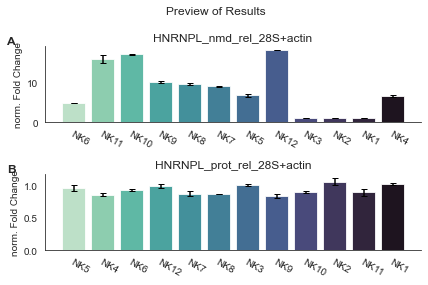

In [6]:
# visualise
fig = results.preview()

At this point you may wonder if there is also a `qpcr.preview` function. Well, there isn't. However, the `qpcr.plot` function is a generic implementation that supports visualisations from `qpcr.Assay`, `qpcr.Results`, `qpcr.Calibrator`, and `qpcr.Filters`.

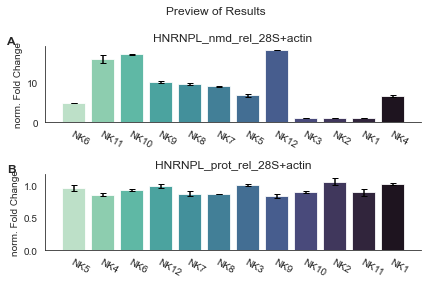

In [7]:
fig = qpcr.plot(results)

Naturally we can also inspect the data directly by either printing the Results object (or it's `get` output) or it's statistical summary using `stats`.

In [8]:
# also show summary statistics view of the results
results.stats()

,group,group_name,assay,n,mean,stdev,median,"IQR_(0.25, 0.75)",CI_0.95
11,5,NK6,HNRNPL_nmd_rel_28S+actin,2,4.842562,0.060002,4.842562,0.060002,"[4.080169048235552, 5.604954117226358]"
21,10,NK11,HNRNPL_nmd_rel_28S+actin,2,15.772739,1.024227,15.772739,1.024227,"[2.7586975862320013, 28.786779942335905]"
19,9,NK10,HNRNPL_nmd_rel_28S+actin,2,16.941957,0.190889,16.941957,0.190889,"[14.516488624589774, 19.36742575285254]"
17,8,NK9,HNRNPL_nmd_rel_28S+actin,2,10.105629,0.226306,10.105629,0.226306,"[7.23013449749268, 12.981123150685496]"
15,7,NK8,HNRNPL_nmd_rel_28S+actin,2,9.623898,0.273373,9.623898,0.273373,"[6.15036182189704, 13.09743362205634]"
13,6,NK7,HNRNPL_nmd_rel_28S+actin,2,8.969974,0.124859,8.969974,0.124859,"[7.383484846018764, 10.55646413477016]"
9,4,NK5,HNRNPL_nmd_rel_28S+actin,2,6.717150,0.295022,6.717150,0.295022,"[2.9685397502667006, 10.465760121873714]"
23,11,NK12,HNRNPL_nmd_rel_28S+actin,2,18.106299,0.005835,18.106299,0.005835,"[18.03216076969107, 18.180436594010164]"
5,2,NK3,HNRNPL_nmd_rel_28S+actin,2,1.037911,0.005383,1.037911,0.005383,"[0.9695147805146154, 1.1063075108984326]"
3,1,NK2,HNRNPL_nmd_rel_28S+actin,2,1.072644,0.015405,1.072644,0.015405,"[0.8769055130766266, 1.2683823879671026]"


With this we have reached the end of this basic introduction. Congrats, you now know the very basics of `qpcr` !